# Project: Predicting Hospital readmission with 30 days of discharge

**Summary:** I worked in a group of 4 to predict hospital readmission within 30 days of a patient's discharge. Each data point is a hospital visit. Some features include patient demographics as well as diagnoses and medical information.

- **Data Cleaning**
    - Originally, the outcome variable had 3-levels, so we converted it to a binary variable to answer the question at hand (admission within 30 days).
    - We found that *weight* was missing from more than 50% of the data, so it would be difficult to accurately impute values. Although domain knowledge tells us that this would be an important variable in predicting hospital readmission in diabetes patients, we decided to drop the variable as it was not usable.
    - Of the many binary features that represent administered medication, we determined a list of features to drop as they showed multicolinearity.
    - The diagnosis code variables had hundreds of possible values. With external research, we were able to identify and bin several diagnosis codes to prevent a large amount of features during one-hot encoding.
- **Data Validation**
    - Training data was split into an 80/20 train/test split.
- **Modeling**
    - The Gaussian Bayes classifier was fit on categorical features only while the Bernoulli Bayes classifiers was fit on continuous features. I created an ensemble which took the average of the predicted probabilities of both classifiers
    - Additional models include Logistic Regression, kNN, and Random Forest. We also implemented an ensemble of all models.
- **Evaluation**
    - We determined that sensitivity (recall) was most important as we wanted to be able to accurately predict readmission among those who actually need to be readmitted and it would be detrimental to miss a patient. Logistic regression resulted in the best recall of 92%.

## ------------------------- NAIVE BAYES -------------------------

In [56]:
#######################################################################################
##################################### NAIVE BAYES #####################################
#######################################################################################


import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn import cross_validation
from scipy.stats import zscore

diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1


#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))

##dign1 ,2 ,3 transformation:
#diabetic.loc[:,'diag_1':'diag_3']=diabetic[['diag_1','diag_2','diag_3']].apply(pd.to_numeric, errors='coerce', axis=1)
#diabetic['diag_1']=pd.cut(diabetic['diag_1'], range(0, 1000, 100))
#diabetic['diag_2']=pd.cut(diabetic['diag_2'], range(0, 1000, 100))
#diabetic['diag_3']=pd.cut(diabetic['diag_3'], range(0, 1000, 100))
#diabetic['diag_1']=diabetic['diag_1'].replace(np.nan, 'other', regex=True)
#diabetic['diag_2']=diabetic['diag_2'].replace(np.nan, 'other', regex=True)
#diabetic['diag_3']=diabetic['diag_3'].replace(np.nan, 'othern', regex=True)

##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])



#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
#diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train_before=diabetic_train


diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_X_before=diabetic_test_X
diabetic_test_Y=diabetic_test['readmitted']
diabetic_test_Y_before=diabetic_test_Y

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

########################## FIND HIGHEST CORRELATED FEATURES ##########################

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = diabetic.columns
    for i in range(0, diabetic.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(diabetic, n=5):
    au_corr = diabetic.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(diabetic)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(diabetic, 20))

#MANUALLY DROP VARIABLES WITH CORRELATION >= 90%
diabetic_train_X = diabetic_train_X.drop(['diabetesMed_No','change_No','gender_Female'],axis=1)

#Drop from test set
diabetic_test_X = diabetic_test_X.drop(['diabetesMed_No','change_No','gender_Female'],axis=1)


################## GAUSSIAN NAIVE BAYES FOR CONTINUOUS VARIABLES ONLY ######################

#Fetch only the numerical features in the train set
diabetic_train_num_X = diabetic_train_X[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

#Fetch only the numerical features in the test set
diabetic_test_num_X = diabetic_test_X[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

#Rename train y and test y
diabetic_train_num_y = diabetic_train_Y
diabetic_test_num_y = diabetic_test_Y

######################## IMPLEMENT GAUSSIAN BAYES CLASSIFIER #########################
gaus_bayes = GaussianNB()
gaus_bayes = gaus_bayes.fit(diabetic_train_num_X,diabetic_train_num_y)

#predictions
gaus_predicted = gaus_bayes.predict(diabetic_test_num_X)
print("Gaussian predictions = ",predicted)

#PROBABILITIES FOR EACH TEST OBS
gaus_probs = gaus_bayes.predict_proba(diabetic_test_num_X)

#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
# diabetic_test_num_X['actual'] = diabetic_test_num_y
# diabetic_test_num_X['predict'] = predicted

#Create Confusion Matrix
cnf_matrix_gaus = confusion_matrix(diabetic_test_Y, gaus_predicted,labels=[1, 0])
print("Gaussian Confusion Matrix = \n",cnf_matrix_gaus)

################## GAUSSIAN NAIVE BAYES FOR CATEGORICAL VARIABLES ONLY ######################

#RETRIEVE CATEGORICAL FEATURES BY DROPPING CONTINUOUS FEATURES
diabetic_train_cat_X = diabetic_train_X.drop(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],axis=1)
diabetic_train_cat_y = diabetic_train_Y
diabetic_test_cat_X = diabetic_test_X.drop(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],axis=1)
diabetic_test_cat_y = diabetic_test_Y

######################## IMPLEMENT BERNOULLI BAYES CLASSIFIER #########################

bern_bayes = BernoulliNB()
bern_bayes = bern_bayes.fit(diabetic_train_cat_X,diabetic_train_cat_y)

#predictions
bern_predicted = bern_bayes.predict(diabetic_test_cat_X)
print("Bernoulli preditcions = ",bern_predicted)

#PROBABILITIES FOR EACH TEST OBS
bern_probs = bern_bayes.predict_proba(diabetic_test_cat_X)

#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
# diabetic_test_cat_X['readmit'] = diabetic_test_cat_y
# diabetic_test_cat_X['predict'] = predicted

#Create Confusion Matrix
cnf_matrix_bern = confusion_matrix(diabetic_test_Y, bern_predicted,labels=[1, 0])
print("Bernoulli Confusion Matrix = \n",cnf_matrix_bern)

######################## GAUSSIAN AND BERNOULLI BAYES ENSEMBLE CLASSIFIER #########################

#Create easy function for mean
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


#Average probability between gaussian and bernoulli
average_probs = []
for i in range(0,len(bern_probs)):
    average_probs.append([mean((gaus_probs[i][0],bern_probs[i][0])),mean((gaus_probs[i][1],bern_probs[i][1]))])

#Determine prediction based on new average probability of 1
complete_predicted = []
for i in range(0,len(average_probs)):
    if average_probs[i][1] >= .5:
        complete_predicted.append(1)
    else:
        complete_predicted.append(0)

#add complete_predicted to diabetic_test
# diabetic_test['readmit'] = diabetic_test_Y
# diabetic_test['predict'] = complete_predicted

from sklearn.metrics import confusion_matrix

cnf_matrix_bayes = confusion_matrix(diabetic_test_Y, complete_predicted,labels=[1, 0])

print('Final Bayes Confusion Matrix : \n', cnf_matrix_bayes)

total1=sum(sum(cnf_matrix_bayes))
#####from confusion matrix calculate accuracy
accuracy1=(cnf_matrix_bayes[0,0]+cnf_matrix_bayes[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cnf_matrix_bayes[0,0]/(cnf_matrix_bayes[0,0]+cnf_matrix_bayes[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cnf_matrix_bayes[1,1]/(cnf_matrix_bayes[1,0]+cnf_matrix_bayes[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_Y,complete_predicted, target_names=target_names))

Gaussian predictions =  [0 1 0 ... 0 0 1]
Gaussian Confusion Matrix = 
 [[  558  1714]
 [ 2069 15558]]
Bernoulli preditcions =  [1 1 0 ... 0 1 1]
Bernoulli Confusion Matrix = 
 [[ 1292   980]
 [ 7378 10249]]
Final Bayes Confusion Matrix : 
 [[  862  1410]
 [ 3502 14125]]
Accuracy :  0.7531534247952159
Sensitivity :  0.37940140845070425
Specificity :  0.8013275089351563
             precision    recall  f1-score   support

    class 0       0.91      0.80      0.85     17627
    class 1       0.20      0.38      0.26      2272

avg / total       0.83      0.75      0.78     19899



## ------------------------------ kNN ------------------------------

In [57]:
#######################################################################################
######################################### kNN #########################################
#######################################################################################

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn import cross_validation
from scipy.stats import zscore

diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))

##dign1 ,2 ,3 transformation:
#diabetic.loc[:,'diag_1':'diag_3']=diabetic[['diag_1','diag_2','diag_3']].apply(pd.to_numeric, errors='coerce', axis=1)
#diabetic['diag_1']=pd.cut(diabetic['diag_1'], range(0, 1000, 100))
#diabetic['diag_2']=pd.cut(diabetic['diag_2'], range(0, 1000, 100))
#diabetic['diag_3']=pd.cut(diabetic['diag_3'], range(0, 1000, 100))
#diabetic['diag_1']=diabetic['diag_1'].replace(np.nan, 'other', regex=True)
#diabetic['diag_2']=diabetic['diag_2'].replace(np.nan, 'other', regex=True)
#diabetic['diag_3']=diabetic['diag_3'].replace(np.nan, 'othern', regex=True)

##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])



#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
#diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train_before=diabetic_train


diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_X_before=diabetic_test_X
diabetic_test_Y=diabetic_test['readmitted']
diabetic_test_Y_before=diabetic_test_Y

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']



############ KNN MODEL WITH K=5 ################
#rom scipy.stats import zscore
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(diabetic_train_X,diabetic_train_Y)
K_pred=knn.predict(diabetic_test_X)

print("kNN Predictions = ",K_pred)

from sklearn.metrics import confusion_matrix


cm13=confusion_matrix(diabetic_test_Y,K_pred,labels=[1, 0])
print("kNN Confusion Matrix = \n",cm13)

accuracy1 = (cm13[0,0]+cm13[1,1])/(len(diabetic_test_Y))
print('Sensitivity : ', sensitivity1 )

sensitivity1 = cm13[0,0]/(cm13[0,0]+cm13[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm13[1,1]/(cm13[1,0]+cm13[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_Y,K_pred, target_names=target_names))



kNN Predictions =  [0 0 0 ... 1 0 0]
kNN Confusion Matrix = 
 [[  828  1444]
 [ 4726 12901]]
Sensitivity :  0.37940140845070425
Sensitivity :  0.3644366197183099
Specificity :  0.7318885800192886
             precision    recall  f1-score   support

    class 0       0.90      0.73      0.81     17627
    class 1       0.15      0.36      0.21      2272

avg / total       0.81      0.69      0.74     19899



## ------------------------------ LOGISTIC REGRESSION ------------------------------

Logistic regression predictions =  [0 1 0 ... 0 0 1]
Logistic Regression Confusion Matrix = 
 [[12062  1000]
 [ 5565  1272]]
Accuracy 0.670083923815267
Sensitivity :  0.9234420456285408
Specificity :  1.8869387158110282
             precision    recall  f1-score   support

          0       0.92      0.68      0.79     17627
          1       0.19      0.56      0.28      2272

avg / total       0.84      0.67      0.73     19899



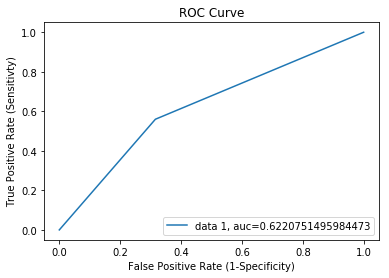

In [61]:
###############################################################################################
##################################### LOGISTIC REGRESSION #####################################
###############################################################################################
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn import cross_validation
from scipy.stats import zscore

diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))

##dign1 ,2 ,3 transformation:
#diabetic.loc[:,'diag_1':'diag_3']=diabetic[['diag_1','diag_2','diag_3']].apply(pd.to_numeric, errors='coerce', axis=1)
#diabetic['diag_1']=pd.cut(diabetic['diag_1'], range(0, 1000, 100))
#diabetic['diag_2']=pd.cut(diabetic['diag_2'], range(0, 1000, 100))
#diabetic['diag_3']=pd.cut(diabetic['diag_3'], range(0, 1000, 100))
#diabetic['diag_1']=diabetic['diag_1'].replace(np.nan, 'other', regex=True)
#diabetic['diag_2']=diabetic['diag_2'].replace(np.nan, 'other', regex=True)
#diabetic['diag_3']=diabetic['diag_3'].replace(np.nan, 'othern', regex=True)

##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])



#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
#diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train_before=diabetic_train


diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_X_before=diabetic_test_X
diabetic_test_Y=diabetic_test['readmitted']
diabetic_test_Y_before=diabetic_test_Y

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']


################## logistic Regression Model
import statsmodels.api as sm
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, roc_curve
from sklearn.metrics import classification_report

## Training model
diabetic_train_X_before = diabetic_train_before.drop('readmitted',axis=1)
diabetic_train_Y_before = diabetic_train_before['readmitted']
LogReg = LogisticRegression(class_weight='balanced')
LogReg.fit(diabetic_train_X_before, diabetic_train_Y_before)
#print(LogReg.score(diabetic_train_X_before, diabetic_train_Y_before))

## Predictions on test set
y_pred = LogReg.predict(diabetic_test_X_before)
print("Logistic regression predictions = ",y_pred)


## Confusion Matrix
cnf_log_matrix = metrics.confusion_matrix(y_pred, diabetic_test_Y_before)
print("Logistic Regression Confusion Matrix = \n", cnf_log_matrix)

print("Accuracy", metrics.accuracy_score(diabetic_test_Y, y_pred))

sensitivity1 = cnf_log_matrix[0,0]/(cnf_log_matrix[0,0]+cnf_log_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm13[1,1]/(cnf_log_matrix[1,0]+cnf_log_matrix[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_Y_before,y_pred))

## AUC curve
fpr, tpr, _ = metrics.roc_curve(diabetic_test_Y_before, y_pred)
auc = metrics.roc_auc_score(diabetic_test_Y_before, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivty)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


## --------------------- logistic regression with new threshold -----------------

In [63]:
diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))


##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)

diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_y=diabetic_test['readmitted']

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_y = diabetic_train['readmitted']

############################# NEW LOGISTIC REGRESSION MODEL #############################
LogReg = LogisticRegression(penalty='l2')
LogReg = LogReg.fit(diabetic_train_X, diabetic_train_y)

y_pred= LogReg.predict(diabetic_test_X)
print("predicted = ",y_pred)

log_probs = LogReg.predict_proba(diabetic_test_X)

new_threshold = []
for i in range(0,len(diabetic_test_y)):
    if log_probs[i][1] >= .5:
        new_threshold.append(1)
    else:
        new_threshold.append(0)

#print("new threshold",new_threshold)

## Confusion Matrix
cnf_log_matrix = metrics.confusion_matrix(new_threshold, diabetic_test_Y_before,labels=[1, 0])
print("Logistic Regression Confusion Matrix = \n", cnf_log_matrix)

print("Accuracy", metrics.accuracy_score(diabetic_test_Y, y_pred))

sensitivity1 = cnf_log_matrix[0,0]/(cnf_log_matrix[0,0]+cnf_log_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm13[1,1]/(cnf_log_matrix[1,0]+cnf_log_matrix[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_Y_before,y_pred))

predicted =  [0 1 0 ... 0 0 1]
Logistic Regression Confusion Matrix = 
 [[ 1281  5609]
 [  991 12018]]
Accuracy 0.6683250414593698
Sensitivity :  0.18592162554426706
Specificity :  0.991698055192559
             precision    recall  f1-score   support

          0       0.92      0.68      0.78     17627
          1       0.19      0.56      0.28      2272

avg / total       0.84      0.67      0.73     19899



## -------------------------------- Random Forest --------------------------------

In [60]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cross_validation


diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)
#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)


#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)

#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)

##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))

bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##change nan to 'unknown' for 'medical_specialty'
diabetic['medical_specialty']=diabetic['medical_specialty'].replace(np.nan, 'unknown', regex=True)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000


#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)


############################# TRAIN/TEST SPLIT #############################
##testing data set: 
diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_test_y = diabetic_test['readmitted']
diabetic_test_X = diabetic_test.drop('readmitted',axis=1)

##training date set: 
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_y = diabetic_train['readmitted']


#diabetic_train.isnull().mean() * 100
diabetic_train_X.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
diabetic_train_X.loc[:,['race', 'gender', 'age','max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'diag_1_new', 'medical_specialty', 'diag_2_new',
       'diag_3_new']]=diabetic_train_X.loc[:,['race', 'gender', 'age','max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'diag_1_new', 'medical_specialty','diag_2_new',
       'diag_3_new']].apply(lambda x:x.astype('category'))
diabetic_train_X=pd.get_dummies(diabetic_train_X)

##testing set dummy varaible transformation:
diabetic_test_X=pd.get_dummies(diabetic_test_X)

missing_column=set(diabetic_test_X.columns).symmetric_difference(set(diabetic_train_X.columns))
missing_column=list(missing_column)
adding=pd.DataFrame(0, index=np.arange(len(diabetic_test_X)), columns=missing_column)
diabetic_test_X=diabetic_test_X.reset_index(drop=True)
diabetic_test_X=diabetic_test_X.join(adding, how='outer')
diabetic_test_X=diabetic_test_X[diabetic_train_X.columns]




##Model building:  
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(bootstrap=True, class_weight= 'balanced_subsample', criterion='entropy',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.001, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

##Cross validation:
print (np.mean(cross_validation.cross_val_score(clf, diabetic_train_X, diabetic_train_y, cv=10)))


##Using all the variables for model building: 

clf.fit(diabetic_train_X, diabetic_train_y)
predict_result=clf.predict(diabetic_test_X)

#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cnf_ran_matrix = confusion_matrix(diabetic_test_Y, predict_result,labels=[1, 0])

print('Random Forest Confusion Matrix : \n', cnf_ran_matrix)


from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_y,predict_result, target_names=target_names))



0.6432985485355907
Random Forest Confusion Matrix : 
 [[ 1334   938]
 [ 6167 11460]]
             precision    recall  f1-score   support

    class 0       0.92      0.65      0.76     17627
    class 1       0.18      0.59      0.27      2272

avg / total       0.84      0.64      0.71     19899



In [64]:
x=[y_pred,complete_predicted,predict_result]

label=[]
    #find rows with k smallest distances
for i in range(0,len(y_pred)):
    sum_=(x[0][i]+x[1][i]+x[2][i])
        #classify point
    if (sum_>=2):
        label.append(1)
    else:
        label.append(0)

#df_confusion = pd.crosstab(diabetic_test_Y, label)
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(diabetic_test_Y, label,labels=[1, 0])

print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_y,label, target_names=target_names))


Confusion Matrix : 
 [[ 1201  1071]
 [ 5176 12451]]
Accuracy :  0.6860646263631338
Sensitivity :  0.5286091549295775
Specificity :  0.7063595620355138
             precision    recall  f1-score   support

    class 0       0.92      0.71      0.80     17627
    class 1       0.19      0.53      0.28      2272

avg / total       0.84      0.69      0.74     19899



In [13]:
c=diabetic_test_y[diabetic_test_y==label]

In [15]:
diabetic_test_y.value_counts()

0    17627
1     2272
Name: readmitted, dtype: int64